# Supervised classification | Loan Lending Club

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import loan_processing as lp
from datetime import datetime as dt
import joblib
import os
import time

#### General settings

In [62]:
rs = 25 # Setting random seed for reproducibility
export_mode = True # If True, exports all models, metrics and information to dedicated output & data folders to be then consumed by the predictions notebook
sampled_mode = False # If True, only a sample of the data is used for training and testing
sample_frac = 0.01 # Fraction of the data to be used for training and testing

# Data Exploration
### Chunked loading

In [63]:
dtype_spec = {48: 'str', 58: 'str', 117: 'str'} # Since those columns where giving Pandas some issues regarding the initial data type

chunk_list = []

chunk_size = 100000

try:
    # Try to access the variable to see if it exists
    len(df_full)
    print(f"Using existing dataframe in memory with {len(df_full)} rows")

except NameError:

    for chunk in pd.read_csv('DATA/Loan_Lending_Club.csv', dtype=dtype_spec, chunksize=chunk_size):
        chunk_list.append(chunk)
        print(f"Chunk {len(chunk_list)} loaded; Total rows: {chunk_size * len(chunk_list)}")
        
    # If df_full doesn't exist, concatenate the chunks
    df_full = pd.concat(chunk_list, ignore_index=True)
    print(f"Total rows loaded: {len(df_full)}")   


Using existing dataframe in memory with 1753431 rows


### Subset sampling for performance

Doing everything will the full dataset would have taken days, so I decided to randomly sample 10% of the data for the initial exploration. Despite the data being sparse it should still have the same characteristics as the full dataset

In [64]:
if sampled_mode:
    df = df_full.sample(frac= sample_frac, random_state= rs)
    print(f"Using a sample of {len(df)} rows corresponding to {sample_frac * 100}% of the initial dataset")
else:
    df = df_full
    print(f"Using the full dataset with {len(df)} rows")

Using the full dataset with 1753431 rows


In [65]:
print(f'Length of full data frame: {len(df_full)}')
print(f'Length of current data frame: {len(df)}')
print("")
print("Dataframe info:")
display(df.info())

Length of full data frame: 1753431
Length of current data frame: 1753431

Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1753431 entries, 0 to 1753430
Columns: 142 entries, Unnamed: 0 to debt_settlement_flag
dtypes: float64(106), int64(2), object(34)
memory usage: 1.9+ GB


None

## Exploring missing values

In [66]:
missing_vals = df.isna().sum() / len(df) * 100
print("Missing values [in % missing per column]:")
missing_vals = missing_vals.sort_values(ascending=False)
print(missing_vals[missing_vals > 0].head(60))
# plt.figure(figsize=(8, 25))
# sns.barplot(x=missing_vals.values, y=missing_vals.index, orient='h')
# plt.xlabel('Percentages of Missing Values')
# plt.ylabel('Column Names')
# plt.title('Missing Values per Column')
# plt.show()


Missing values [in % missing per column]:
hardship_loan_status                          96.273249
hardship_reason                               96.268459
hardship_status                               96.268345
hardship_type                                 96.268231
payment_plan_start_date                       96.268231
hardship_end_date                             96.268231
deferral_term                                 96.268231
hardship_start_date                           96.268231
hardship_length                               96.268231
hardship_dpd                                  96.268231
orig_projected_additional_accrued_interest    95.352597
hardship_amount                               95.227186
hardship_last_payment_amount                  95.227186
hardship_payoff_balance_amount                95.227186
sec_app_revol_util                            94.386092
revol_bal_joint                               94.286117
sec_app_earliest_cr_line                      94.286060
sec_ap

## Defining the target column

There is 7 different status options for the target column. To simplify we will focus on closed loans and loans that are still active.

**Closed loans:**
- **Fully Paid** --- Target Class
- Default
- Charged Off

**Active loans:**
- Current
- Late (16-30 days)
- Late (31-120 days)
- In Grace Period

In [ ]:
display(df['loan_status'].value_counts())

df = lp.create_target_columns(df, 'loan_status')

## Separating active loans for the business predictions later on
df_active = df[df['active_loan'] == 1]

if export_mode:
    if os.exists('DATA/active_loans.parquet'):
        df_active.to_parquet('DATA/active_loans.parquet', index=False)

loan_status
Fully Paid            1045784
Current                423402
Charged Off            269242
Late (31-120 days)       8461
In Grace Period          4993
Late (16-30 days)        1336
Default                   212
Name: count, dtype: int64

Target columns created: active_loan, default


### Analyzing the target column

In [68]:
# Create a dataframe to display the interaction between closed/active and status
target_df = df.groupby(['active_loan', 'loan_status']).size().reset_index(name='counts')
target_df['Total %'] = round(target_df['counts'] / len(df) * 100, 2)
target_df.set_index(['active_loan', 'loan_status'], inplace=True)
display(target_df)

print("Distribution of active loans:")
active_df = target_df.loc[1].copy()
active_df['Active %'] = round(active_df['counts'] / active_df['counts'].sum() * 100, 2)
display(active_df)

print("Distribution of closed loans:")
closed_df = target_df.loc[0].copy()
closed_df['Closed %'] = round(closed_df['counts'] / closed_df['counts'].sum() * 100, 2)
display(closed_df)

# Exporting the target insights to Excel
if export_mode:
    target_df.to_excel('OUTPUT/target_insights.xlsx', sheet_name='Target Analysis', index=False)

counts  Total %
active_loan loan_status                         
0           Charged Off          269242    15.36
            Default                 212     0.01
            Fully Paid          1045784    59.64
1           Current              423402    24.15
            In Grace Period        4993     0.28
            Late (16-30 days)      1336     0.08
            Late (31-120 days)     8461     0.48

Distribution of active loans:


,counts,Total %,Active %
loan_status,,,
Current,423402,24.15,96.62
In Grace Period,4993,0.28,1.14
Late (16-30 days),1336,0.08,0.30
Late (31-120 days),8461,0.48,1.93


Distribution of closed loans:


,counts,Total %,Closed %
loan_status,,,
Charged Off,269242,15.36,20.47
Default,212,0.01,0.02
Fully Paid,1045784,59.64,79.51


#### Determining class weights

In [69]:
print(df['default'].value_counts())

pos_class_count = df['default'].value_counts().get(1, 0)  # Class 1 (loan will default)
neg_class_count = df['default'].value_counts().get(0, 0)  # Class 0 (loan will be paid)

pos_class_ratio = pos_class_count / neg_class_count

print(f"There are {pos_class_ratio:.2f} times more paid loans than defaults")

default
0    1045784
1     707647
Name: count, dtype: int64
There are 0.68 times more paid loans than defaults


### Setting X and y

In [70]:
# Featureset
X = df.drop(['default'], axis=1)
X = X[X['active_loan'] == 0]
print(f'There are currently {len(X.columns)} columns in the featureset')

# Target 
y = df[['default']][df['active_loan'] == 0]

X.shape, y.shape


There are currently 143 columns in the featureset


((1315238, 143), (1315238, 1))

### Exploring average recoveries

In [71]:
# Average percent of recoveries from overall funded amounts per loan grade

avg_recoveries_by_grade = df.groupby('grade')['recoveries'].mean() / df.groupby('grade')['funded_amnt'].mean()

# Export dictionary with the average recovery rates per grade
if export_mode:
    recovery_dict = (avg_recoveries_by_grade).to_dict()
    with open('DATA/recovery_info.json', 'w') as f:
        json.dump(recovery_dict, f)

display(avg_recoveries_by_grade)

grade
A    0.002893
B    0.007860
C    0.015271
D    0.023707
E    0.034181
F    0.045424
G    0.051605
dtype: float64

## Initial columns drops

Dropping columns that are not useful for the model just based on their title 

In [72]:
# Dropping all hardship columns
hardship_cols = [col for col in X.columns if 'hardship' in col] + [
    'payment_plan_start_date',
    'orig_projected_additional_accrued_interest',
    'deferral_term',
    'debt_settlement_flag' # Because it basically indicates that the loan has already defaulted
]

# Droping joint application columns

joint_app_cols = [col for col in X.columns if 'sec_app' in col] + [
    'annual_inc_joint',
    'dti_joint',
    'verification_status_joint',
    'revol_bal_joint'
]

# Defining all columns to be dropped

drop_cols = [
    'loan_status', # Target column

    # Loan information
    'url',
    'id',
    'Unnamed: 0',

    # Borrower information
    'zip_code',
    'addr_state',
    'emp_title',
    'policy_code',
    'purpose',
    'title',

    # Further assumed data leakage
    'next_pymnt_d', # since it indicates an active loan
    'last_pymnt_d', # if it's in the past it will indicate a closed loan
    'recoveries', # Data leakage
    'collection_recovery_fee', # Data leakage
    'last_pymnt_amnt', # Data leakage

    # Duplicate information
    'total_rec_prncp', # Opposite of outstanding principle, so we can discard it since they have negative correlation
    'total_rec_int', # Same as above but for interest
    'total_rec_late_fee', # Same as above but for late fees
    'total_pymnt',
    'total_pymnt_inv'
] + hardship_cols + joint_app_cols 

# Defining a column dropped set to keep track of all columns dropped and export them later to apply the same logic to the open loans
total_dropped = set()
total_dropped.update(drop_cols)
print(f"Total columns to be dropped: {len(total_dropped)}")

# Finally executing all column drops
for col in drop_cols:
    if col in X.columns:
        X.drop(col, axis=1, inplace=True)
        print(f"Column {col} dropped.")
    else:
        print(f"Column {col} not found. Might have been dropped already.")


Total columns to be dropped: 51
Column loan_status dropped.
Column url dropped.
Column id dropped.
Column Unnamed: 0 dropped.
Column zip_code dropped.
Column addr_state dropped.
Column emp_title dropped.
Column policy_code dropped.
Column purpose dropped.
Column title dropped.
Column next_pymnt_d dropped.
Column last_pymnt_d dropped.
Column recoveries dropped.
Column collection_recovery_fee dropped.
Column last_pymnt_amnt dropped.
Column total_rec_prncp dropped.
Column total_rec_int dropped.
Column total_rec_late_fee dropped.
Column total_pymnt dropped.
Column total_pymnt_inv dropped.
Column hardship_flag dropped.
Column hardship_type dropped.
Column hardship_reason dropped.
Column hardship_status dropped.
Column hardship_amount dropped.
Column hardship_start_date dropped.
Column hardship_end_date dropped.
Column hardship_length dropped.
Column hardship_dpd dropped.
Column hardship_loan_status dropped.
Column hardship_payoff_balance_amount dropped.
Column hardship_last_payment_amount d

In [73]:
len(drop_cols)

51

# Data Cleaning & Feature Engineering


### Reevaluating the missing values

In [74]:
X.isna().sum().sort_values(ascending=False).head(50) / len(X)

mths_since_last_record            8.249062e-01
mths_since_recent_bc_dlq          7.533359e-01
mths_since_last_major_derog       7.202050e-01
mths_since_recent_revol_delinq    6.537798e-01
il_util                           5.466098e-01
mths_since_last_delinq            4.967656e-01
mths_since_rcnt_il                4.862230e-01
all_util                          4.703149e-01
inq_last_12m                      4.702396e-01
total_cu_tl                       4.702396e-01
open_acc_6m                       4.702396e-01
open_rv_12m                       4.702388e-01
open_act_il                       4.702388e-01
max_bal_bc                        4.702388e-01
open_il_24m                       4.702388e-01
open_il_12m                       4.702388e-01
open_rv_24m                       4.702388e-01
total_bal_il                      4.702388e-01
inq_fi                            4.702388e-01
mths_since_recent_inq             9.958730e-02
emp_length                        6.456018e-02
num_tl_120dpd

## Handling missing values

for the above missing values columns we will define replacement strategies, by classifying them into 3 categories:

- **months_since_...** columns: missing values will be replaced with a -1 since 0 would indicated a deliquency happening in the most recent month
- **utilization_rate**: missing values will be replaced with 0, since it is a ratio and 0 is a valid value


## Convert data types

There are still some data types that need to be converted to the correct type or one hot encoded

In [75]:
# Non-numeric and string columns
non_numeric_cols = X.select_dtypes(include='object').columns
print("Non-numeric columns:")
for col in non_numeric_cols:
    print(col)
    print(X[col].unique())

Non-numeric columns:
term
[' 36 months' ' 60 months']
int_rate
['  7.97%' '  9.44%' ' 16.02%' ' 13.59%' ' 23.88%' ' 17.09%' ' 28.72%'
 ' 11.99%' ' 30.84%' ' 24.85%' ' 21.45%' ' 19.03%' ' 12.62%' '  7.07%'
 ' 14.08%' ' 10.91%' ' 15.05%' ' 20.00%' '  5.32%' ' 18.06%' '  9.93%'
 '  7.35%' ' 30.65%' '  7.21%' ' 10.42%' ' 30.89%' ' 29.69%' ' 30.17%'
 ' 26.30%' ' 25.82%' ' 30.75%' ' 30.94%' ' 30.99%' ' 22.91%' ' 30.79%'
 '  6.00%' '  6.72%' '  6.08%' ' 23.87%' ' 14.07%' ' 11.98%' ' 20.39%'
 '  9.43%' ' 16.01%' ' 10.90%' ' 13.58%' '  9.92%' ' 10.41%' ' 15.04%'
 '  7.96%' ' 17.47%' '  7.34%' '  6.07%' ' 21.85%' '  5.31%' ' 18.45%'
 ' 12.61%' ' 26.77%' '  6.71%' ' 25.81%' ' 19.42%' ' 24.84%' ' 22.90%'
 '  7.46%' ' 10.07%' '  6.83%' ' 14.52%' ' 10.56%' ' 13.06%' '  8.08%'
 ' 14.03%' ' 16.46%' ' 15.49%' '  9.58%' '  6.19%' ' 11.05%' ' 12.13%'
 '  7.84%' ' 13.56%' ' 22.35%' ' 17.97%' ' 18.94%' ' 16.14%' ' 11.55%'
 '  8.46%' '  6.67%' ' 15.02%' ' 11.06%' ' 20.89%' ' 14.47%' ' 16.91%'
 ' 12.73%' '  

## Transformations

### Date Transformations

In [76]:

date_cols = ['earliest_cr_line', 'last_credit_pull_d']

X = lp.process_year_month_date(X, 'issue_d')
X = lp.process_month_date(X, date_cols)

### Adjust percentages

In [77]:
pct_cols = ['revol_util', 'int_rate']

X = lp.process_percentages(X, pct_cols)

### Adjust term columns

In [78]:
X = lp.process_term(X, 'term')

## High-correlation feature matrix

In [79]:
# Find highly correlated features (absolute correlation > 0.9)
threshold = 0.90
numerical_cols = X.select_dtypes(include='number').columns
corr_matrix = X[numerical_cols].corr()

high_corr_matrix = corr_matrix[corr_matrix.abs() > threshold]

# Create a DataFrame to store the highly correlated pairs
high_corr_features = []

# Find feature pairs with correlation above threshold
for i in range(len(corr_matrix.columns)):
    for j in range(i):  
        if abs(corr_matrix.iloc[i, j]) > threshold:
            feature1 = corr_matrix.columns[i]
            feature2 = corr_matrix.columns[j]
            corr_value = corr_matrix.iloc[i, j]
            high_corr_features.append((feature1, feature2, corr_value))

corr_df = pd.DataFrame(high_corr_features, columns=['Feature 1', 'Feature 2', 'Correlation'])
corr_df.sort_values(by='Correlation', ascending=False, inplace=True)

display(corr_df)

,Feature 1,Feature 2,Correlation
6,fico_range_high,fico_range_low,1.000000
7,out_prncp_inv,out_prncp,0.999999
0,funded_amnt,loan_amnt,0.999999
2,funded_amnt_inv,funded_amnt,0.999994
1,funded_amnt_inv,loan_amnt,0.999994
9,num_sats,open_acc,0.998833
8,num_rev_tl_bal_gt_0,num_actv_rev_tl,0.981963
10,tot_hi_cred_lim,tot_cur_bal,0.971950
12,total_il_high_credit_limit,total_bal_il,0.956302
4,installment,funded_amnt,0.950080


#### Plotting the matrices

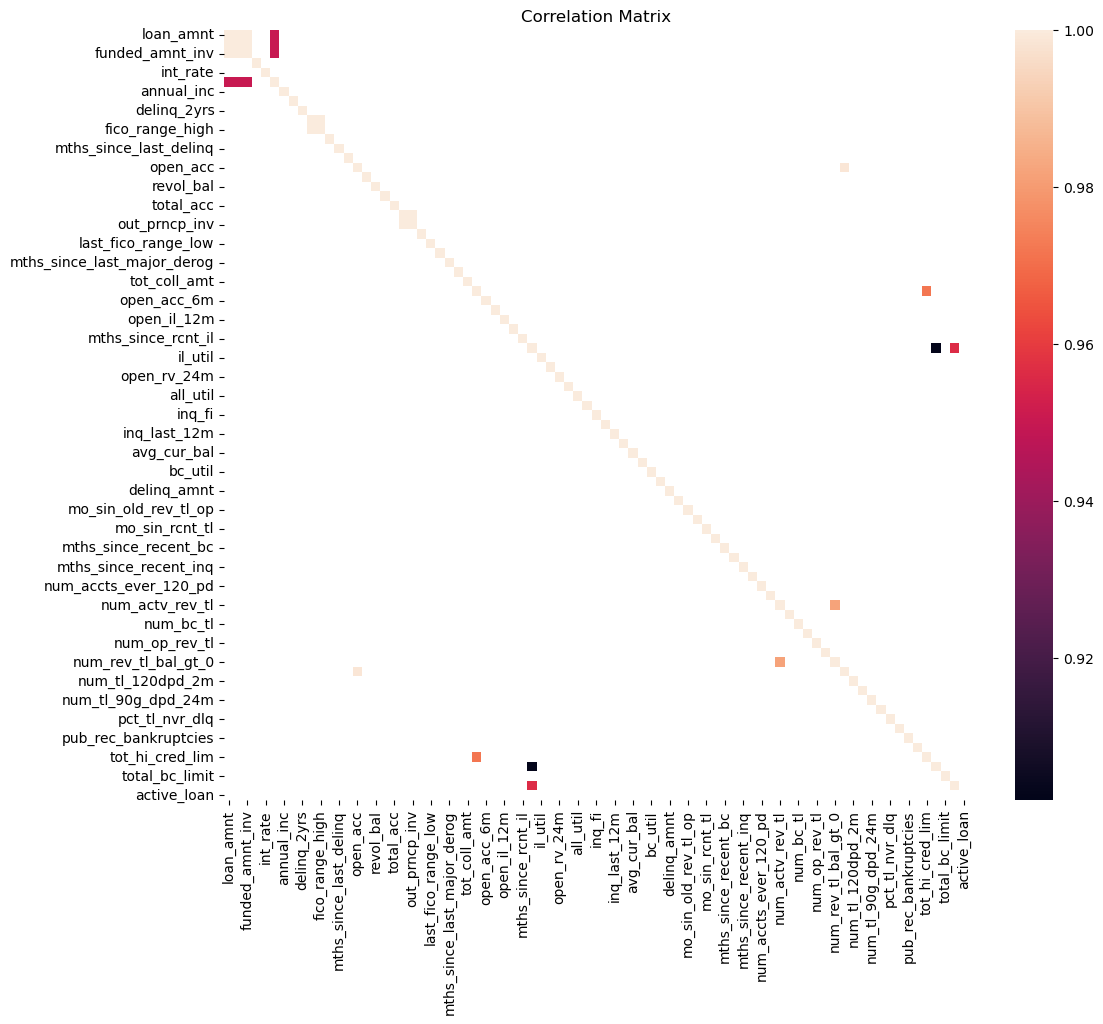

In [80]:
plt.figure(figsize=(12, 10))
sns.heatmap(high_corr_matrix, annot=False, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

c:\Users\timos\miniconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\timos\miniconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


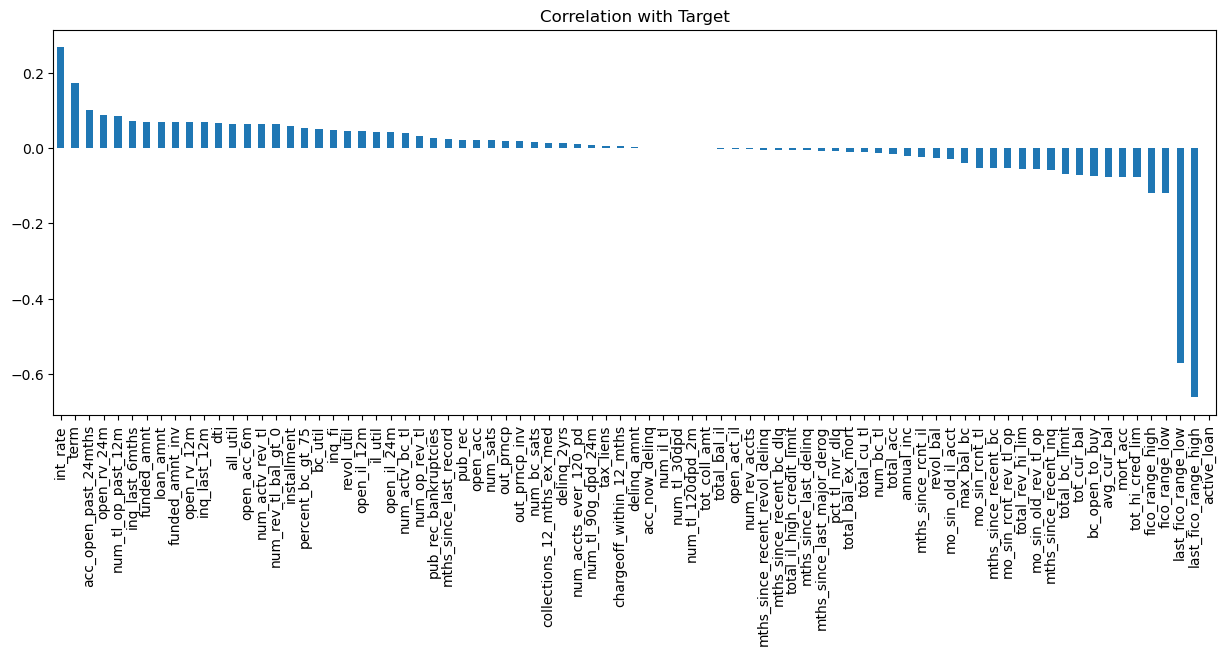

In [81]:
plt.figure(figsize=(15, 5))
target_correlations = X[numerical_cols].corrwith(y['default']).sort_values(ascending=False)
target_correlations.plot(kind='bar')
plt.title('Correlation with Target')
plt.show()

### Dropping 2.0 based on insights from correlation matrix

In [82]:
# Create a list of features to potentially drop
# Strategy: From each pair, keep the first feature (you could implement a more sophisticated approach)
high_corr_drop = []
for _, feature2, _ in high_corr_features:
    if feature2 not in high_corr_drop:
        high_corr_drop.append(feature2)

print("Features to consider dropping to reduce multicollinearity:")
for col in high_corr_drop:
    print(f"- {col}")

Features to consider dropping to reduce multicollinearity:
- loan_amnt
- funded_amnt
- funded_amnt_inv
- fico_range_low
- out_prncp
- num_actv_rev_tl
- open_acc
- tot_cur_bal
- total_bal_il


## Creating new features

In [83]:
X = lp.create_fico_features(X, verbose = True)

New features created: avg_fico_start, avg_fico_current, fico_diff fico_downgrade
FICO features summary:
       avg_fico_start  avg_fico_current     fico_diff  fico_downgrade
count    1.315238e+06      1.315238e+06  1.315238e+06    1.315238e+06
mean     6.987251e+02      6.680393e+02 -3.068579e+01    5.252266e-01
std      3.245462e+01      1.053654e+02  1.010591e+02    4.993634e-01
min      6.620000e+02      0.000000e+00 -8.020000e+02    0.000000e+00
25%      6.720000e+02      6.220000e+02 -7.500000e+01    0.000000e+00
50%      6.920000e+02      6.920000e+02 -5.000000e+00    1.000000e+00
75%      7.170000e+02      7.320000e+02  3.000000e+01    1.000000e+00
max      8.475000e+02      8.475000e+02  1.855000e+02    1.000000e+00


### Dropping high correlation & engineered features

In [84]:
drop_cols = high_corr_drop + date_cols + [
    'issue_d',
    'maturity_date',
    'fico_range_high',
    'fico_range_low',
    'last_fico_range_high',
    'last_fico_range_low'
] + date_cols

total_dropped.update(drop_cols)

timestamp = dt.now().strftime("%Y%m%d_%H%M%S")

with open(f'OUTPUT/Processing/dropped_columns_{timestamp}.json', 'w') as f:
    json.dump(list(total_dropped), f)

for col in drop_cols:
    if col in X.columns:
        X.drop(col, axis=1, inplace=True)
        print(f"Column {col} dropped.")
    else:
        print(f"Column {col} not found. Might have been dropped already.")

Column loan_amnt dropped.
Column funded_amnt dropped.
Column funded_amnt_inv dropped.
Column fico_range_low dropped.
Column out_prncp dropped.
Column num_actv_rev_tl dropped.
Column open_acc dropped.
Column tot_cur_bal dropped.
Column total_bal_il dropped.
Column earliest_cr_line dropped.
Column last_credit_pull_d dropped.
Column issue_d dropped.
Column maturity_date not found. Might have been dropped already.
Column fico_range_high dropped.
Column fico_range_low not found. Might have been dropped already.
Column last_fico_range_high dropped.
Column last_fico_range_low dropped.
Column earliest_cr_line not found. Might have been dropped already.
Column last_credit_pull_d not found. Might have been dropped already.


## Defining columns for preprocessing

In [85]:
categorical_cols = [
    'application_type', 
    'initial_list_status', 
    'pymnt_plan',
    'grade',
    'sub_grade',
    'home_ownership']

# Lastly defining the categories for the ordinal columns
ordinal_cols = ['emp_length', 
                # 'home_ownership', 
                # 'grade', 
                # 'sub_grade',
                'verification_status']

emp_length_categories = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']
#home_ownership_categories = ['NONE', 'RENT', 'MORTGAGE', 'OWN', 'ANY']
#grade_categories = ['G', 'F', 'E', 'D', 'C', 'B', 'A']
#subgrade_categories = ['G5', 'G4', 'G3', 'G2', 'G1', 'F5', 'F4', 'F3', 'F2', 'F1', 'E5', 'E4', 'E3', 'E2', 'E1', 'D5', 'D4', 'D3', 'D2', 'D1', 'C5', 'C4', 'C3', 'C2', 'C1', 'B5', 'B4', 'B3', 'B2', 'B1', 'A5', 'A4', 'A3', 'A2', 'A1']
verification_status = ['Unknown','Not Verified', 'Source Verified', 'Verified']

categories = [
    emp_length_categories, 
    # home_ownership_categories, 
    # grade_categories,
    # subgrade_categories, 
    verification_status]

### ---- Columns with missing values, that need to be imputed ---- ### 

# Columns that have a trailing time, meaning they track the time since the last event; 
# If nothing happened, 0 would make it seems as if it happened last month, so we give -1

trailing_time_cols = [col for col in X.columns if '_sin' in col]

# Columns that track the balance of something, if missing, we can assume it's 0

balance_cols = [
    'tot_cur_bal', 
    'il_util', 
    'bc_util', 
    'tot_coll_amt', 
    'total_bal_il',
    'max_bal_bc',
    'all_util', 
    'total_rev_hi_lim', 
    'avg_cur_bal',
    'bc_open_to_buy', 
    'total_bal_ex_mort',
    'total_bc_limit'
]

balance_cols = [col for col in balance_cols if col not in high_corr_drop]

# Columns that track the count of something, if missing, we can assume it's 0

count_cols = [
    'open_acc_6m', 
    'open_il_12m', 
    'open_il_24m', 
    'open_rv_12m', 
    'open_rv_24m',
    'inq_fi', 
    'total_cu_tl', 
    'inq_last_12m', 
    'acc_open_past_24mths',
    'mort_acc', 
    'num_accts_ever_120_pd', 
    'num_actv_bc_tl', 
    'num_actv_rev_tl',
    'num_bc_sats', 
    'num_bc_tl', 
    'num_il_tl', 
    'num_op_rev_tl', 
    'num_rev_accts',
    'num_rev_tl_bal_gt_0', 
    'num_sats', 
    'num_tl_op_past_12m',
    'acc_now_delinq', 
    'num_tl_120dpd_2m', 
    'num_tl_30dpd', 
    'num_tl_90g_dpd_24m'
]

count_cols = [col for col in count_cols if col not in high_corr_drop]

ratio_cols = ['pct_tl_nvr_dlq', 'percent_bc_gt_75', 'il_util', 'bc_util', 'all_util', 'total_rev_hi_lim']
ratio_cols = [col for col in ratio_cols if col not in high_corr_drop]

transformed_cols = date_cols + pct_cols + categorical_cols + ordinal_cols + trailing_time_cols + balance_cols + count_cols + ratio_cols
numerical_cols = [col for col in X.columns if col not in transformed_cols and isinstance(X[col].iloc[0], (int, float))]

# Check for duplicate and missing columns

missing_cols = [col for col in X.columns if col not in transformed_cols + numerical_cols]

if missing_cols:
    print("Missing columns:")
    for col in missing_cols:
        print(col)
else:
    print("All columns accounted for the preprocessing steps")

Missing columns:
term
active_loan
fico_downgrade


## Preprocessing

In [86]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# Create preprocessing for ordinal columns that includes imputation first
# We'll use a separate pipeline for ordinal columns to handle missing values first
ordinal_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder(categories=categories, handle_unknown="use_encoded_value", unknown_value=-1))
])

# Create preprocessing for binary columns with missing value handling
binary_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

pre_steps = [
    ('binary_transformer', binary_pipe, categorical_cols),
    ('ordinal_transformer', ordinal_pipe, ordinal_cols),
    ('imputer_trailing', SimpleImputer(strategy='constant', fill_value=-1), trailing_time_cols),
    ('imputer_zero', SimpleImputer(strategy='constant', fill_value=0), count_cols),
    ('imputer_balance', SimpleImputer(strategy='median'), balance_cols),
    ('scaler', StandardScaler(), numerical_cols)
]

pre_pipe = ColumnTransformer(pre_steps, remainder='passthrough', verbose_feature_names_out = False)

### Fitting & Exporting the preprocessor

In [87]:

X_transformed = pre_pipe.fit_transform(X.drop('active_loan', axis=1))

if export_mode:
    joblib.dump(pre_pipe, f'OUTPUT/Processing/preprocessing_pipeline_{timestamp}.pkl')

### Creating first baseline model to assess feature importance

In [88]:
if sampled_mode and sample_frac < 0.05: # Skip in full training mode
    from sklearn.ensemble import RandomForestClassifier

    rfc = RandomForestClassifier(n_estimators=100, random_state = rs)
    rfc.fit(X_transformed, y)

    # Extract feature importances

    feature_importances = rfc.feature_importances_
    feature_names = pre_pipe.get_feature_names_out()

    feature_importances_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

    print(f'Total features: {len(feature_importances_df)}')
    print("Top 50 features:")

    plt.figure(figsize=(15, 10))
    sns.barplot(x='importance', y='feature', data=feature_importances_df.head(50))
    plt.title('Feature Importances')
    plt.show()

# Setting up the GridSearch

Since our dataset also contains loans that are still active, we will split the dataset into training and test set based on the target column. This way we can ensure that the model is not trained on loans that are still active.

In [89]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Custom scorer that combines f1 and recall with more weight on recall
def weighted_score(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    # 70% weight on recall, 30% on F1
    return 0.3 * f1 + 0.7 * recall

loan_scorer = make_scorer(weighted_score)

In [92]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import time
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
import numpy as np
import os
import multiprocessing

# Set number of threads for efficient parallel processing

n_cores = multiprocessing.cpu_count()
n_jobs = max(1, n_cores - 2) 

print(f"System has {n_cores} cores, using {n_jobs} for parallel processing")

# Control thread usage in underlying libraries
os.environ["OMP_NUM_THREADS"] = "2" 
os.environ["OPENBLAS_NUM_THREADS"] = "2"
os.environ["MKL_NUM_THREADS"] = "2" 

start_time = time.time()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_transformed, np.ravel(y), test_size=0.2, random_state=rs, stratify=y)

print(f"Training set shape: {X_train.shape}")

# Define the models with some initial hyperparameters (based on previous tuning)
xgb_model = XGBClassifier(
    random_state=rs,
    max_depth=5,
    n_estimators=250,
    learning_rate=0.05,
    scale_pos_weight=pos_class_ratio,
    subsample=0.8,          
    colsample_bytree=0.8,
    n_jobs=1  
)

lgb_model = lgb.LGBMClassifier(
    random_state=rs,
    verbose=-1,
    num_leaves=31,
    max_depth=3,
    n_estimators=250,
    learning_rate=0.05,
    scale_pos_weight=pos_class_ratio,
    subsample=0.8,            
    colsample_bytree=0.8,
    n_jobs=1 
)

# Use SMOTE for oversampling
smote = SMOTE(sampling_strategy='minority', random_state=rs, k_neighbors=5)

smote_pipe = ImbPipeline([
    ('imputer', SimpleImputer(strategy='mean')), 
    ('smote', smote),
    ('ensemble', VotingClassifier(
        estimators=[
            ('xgb', xgb_model),
            ('lgb', lgb_model)
        ],
        voting='soft',
        n_jobs=1  
    ))
])

param_distributions = {

    # Initial imputer strategy

    'imputer__strategy': ['mean', 'median'],

    # XGBoost parameters
    'ensemble__xgb__scale_pos_weight': [pos_class_ratio, pos_class_ratio * 1.5],
    'ensemble__xgb__n_estimators': [100, 200],

    # LightGBM parameters
    'ensemble__lgb__scale_pos_weight': [pos_class_ratio, pos_class_ratio * 1.5],
    'ensemble__lgb__n_estimators': [100, 200]
}

n_iter = 10 
cv_folds = 3 


random_search = RandomizedSearchCV(
    smote_pipe,
    param_distributions=param_distributions,
    n_iter=n_iter,
    cv=cv_folds,
    scoring=loan_scorer,
    n_jobs=n_jobs,  
    verbose=2,
    random_state=rs,
    error_score='raise',
    pre_dispatch='2*n_jobs' 
)

# Fit the model
print("Starting lightweight RandomizedSearchCV with optimized CPU usage...")
random_search.fit(X_train, y_train)

print(f"Best weighted score: {random_search.best_score_:.4f}")

end_time = time.time()
print(f"Total time taken: {(end_time - start_time) / 60:.2f} minutes")

System has 8 cores, using 6 for parallel processing
Training set shape: (1052190, 126)
Starting lightweight RandomizedSearchCV with optimized CPU usage...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best weighted score: 0.9021
Total time taken: 80.33 minutes


In [93]:
random_search.best_params_

{'imputer__strategy': 'mean',
 'ensemble__xgb__scale_pos_weight': np.float64(0.6766665009217965),
 'ensemble__xgb__n_estimators': 200,
 'ensemble__lgb__scale_pos_weight': np.float64(1.0149997513826947),
 'ensemble__lgb__n_estimators': 200}

### Storing the best model and its metrics

In [94]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

best_model = random_search.best_estimator_

os.makedirs('OUTPUT', exist_ok=True)

if sampled_mode:
    model_filename = f'OUTPUT/Models/best_xgboost_small_{timestamp}.pkl'
    metrics_filename = f'OUTPUT/Metrics/model_metrics_small_{timestamp}.xlsx'
elif len(df) == len(df_full):
    model_filename = f'OUTPUT/Models/best_xgboost_full_{timestamp}.pkl'
    metrics_filename = f'OUTPUT/Metrics/model_metrics_full_{timestamp}.xlsx'
else:
    print("No model saved. Please specify if the model was trained on the full dataset or a sample.")
    model_filename = None

if export_mode:
    joblib.dump(best_model, model_filename)
    print(f"Model saved to {model_filename}")

# Create metrics dataframe

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)
pct_matrix = conf_matrix / len(y_test) * 100

metrics_df = pd.DataFrame({
    'Metric': ['Scoring Metric', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'Best Parameters', 'Dataset Size', 'Sample Fraction', 'Start Time', 'End Time', 'Training Time [minutes]'],
    'Value': [
        str(loan_scorer),
        accuracy_score(y_test, y_pred), 
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred), 
        f1_score(y_test, y_pred),
        roc_auc,
        str(random_search.best_params_),
        len(df),
        sample_frac if sampled_mode else 1.0,
        dt.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S'),
        dt.fromtimestamp(end_time).strftime('%Y-%m-%d %H:%M:%S'),
        (end_time - start_time)/60
        ]
})

if export_mode:
    # Save metrics to Excel
    with pd.ExcelWriter(metrics_filename) as writer:
        metrics_df.to_excel(writer, sheet_name='Summary', index=False)
        pd.DataFrame(report).transpose().to_excel(writer, sheet_name='Classification Report')
        pd.DataFrame(conf_matrix).to_excel(writer, sheet_name='Confusion Matrix')
        
    print(f"Model metrics saved to {metrics_filename}")

Model saved to OUTPUT/Models/best_xgboost_full_20250317_213829.pkl
Model metrics saved to OUTPUT/Metrics/model_metrics_full_20250317_213829.xlsx


## Evaluating the best model

,Metric,Value
0,Scoring Metric,"make_scorer(weighted_score, response_method='p..."
1,Accuracy,0.901858
2,Precision,0.759651
3,Recall,0.762075
4,F1,0.760861
5,ROC AUC,0.948081
6,Best Parameters,"{'imputer__strategy': 'mean', 'ensemble__xgb__..."
7,Dataset Size,1753431
8,Sample Fraction,1.0
9,Start Time,2025-03-17 21:49:49


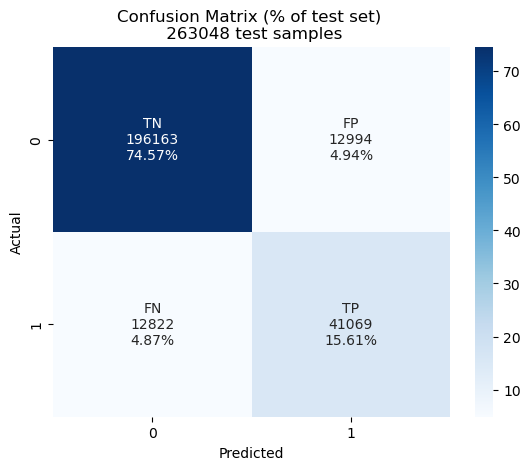

In [95]:
display(metrics_df)

# Plot confusion matrix
group_names = ['TN', 'FP', 'FN', 'TP']
group_counts = [f"{value:0.0f}" for value in conf_matrix.flatten()]
group_percentages = [f"{value:.2f}%" for value in pct_matrix.flatten()]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(pct_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (% of test set) \n {len(y_test)} test samples')
plt.show()

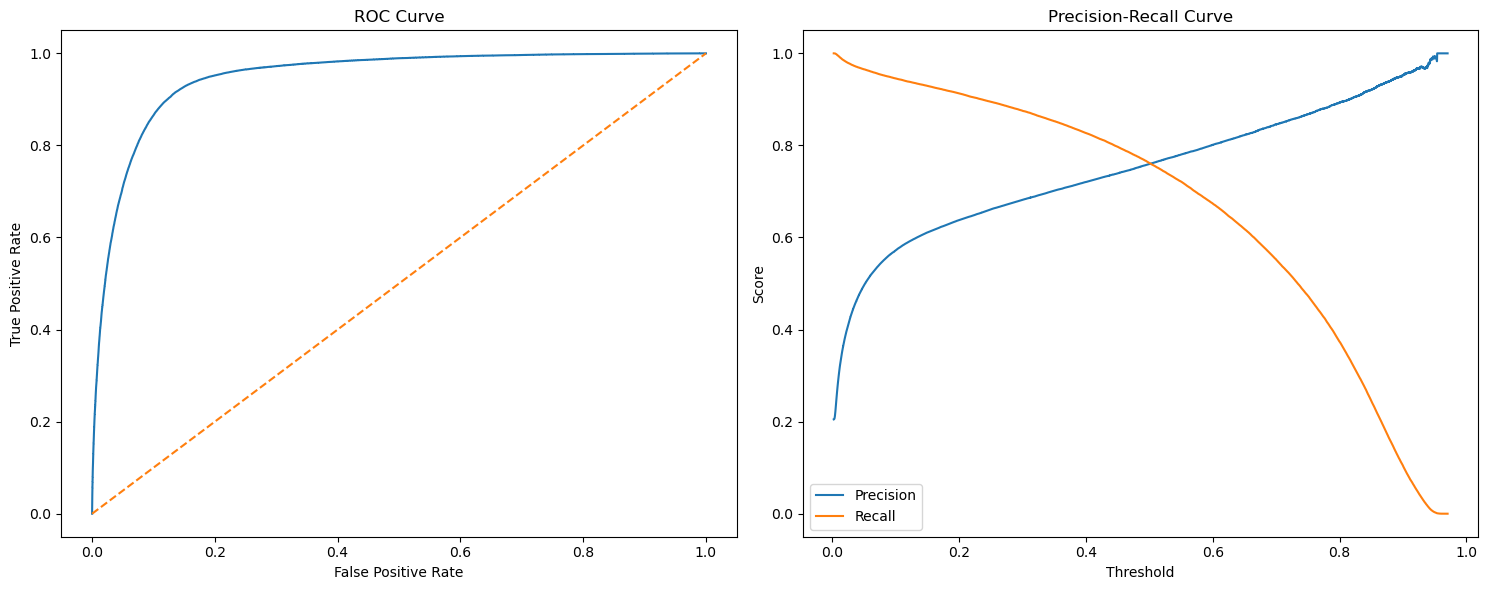

In [96]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve

# Get model probabilities
y_proba = best_model.predict_proba(X_test)[:, 1]

# Precision-recall curve to adjust threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)

# Create figure with two subplots
fig, (roc_ax, pr_ax) = plt.subplots(1, 2, figsize=(15, 6))

# Plot ROC curve
roc_ax.plot(fpr, tpr)
roc_ax.plot([0, 1], [0, 1], '--')
roc_ax.set_xlabel('False Positive Rate')
roc_ax.set_ylabel('True Positive Rate')
roc_ax.set_title('ROC Curve')

# Plot Precision-Recall curve
pr_ax.plot(thresholds, precision[:-1], label="Precision")
pr_ax.plot(thresholds, recall[:-1], label="Recall")
pr_ax.set_xlabel("Threshold")
pr_ax.set_ylabel("Score")
pr_ax.legend()
pr_ax.set_title('Precision-Recall Curve')

plt.tight_layout()
plt.show()
